# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database.
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


CUDA is not available. Training on CPU ...


100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # convert from Tensor image
    plt.show()


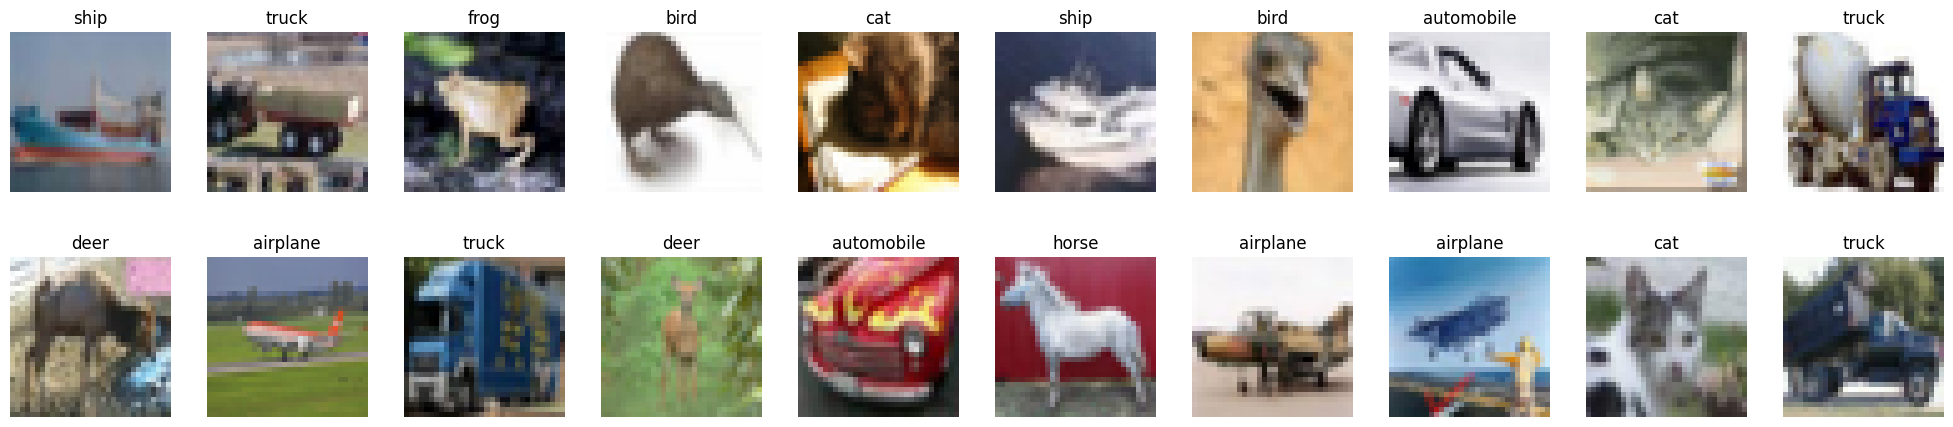

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Move images to CPU for display
if train_on_gpu:
    images = images.cpu().numpy()  # Convert to NumPy array if on GPU
else:
    images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(25, 5))
fig.subplots_adjust(hspace=0.4)

# Display 20 images
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Un-normalize each image
        img = images[idx] / 2 + 0.5
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        ax.imshow(img)
        ax.set_title(classes[labels[idx].item()], fontsize=12)
        ax.axis('off')

plt.show()

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

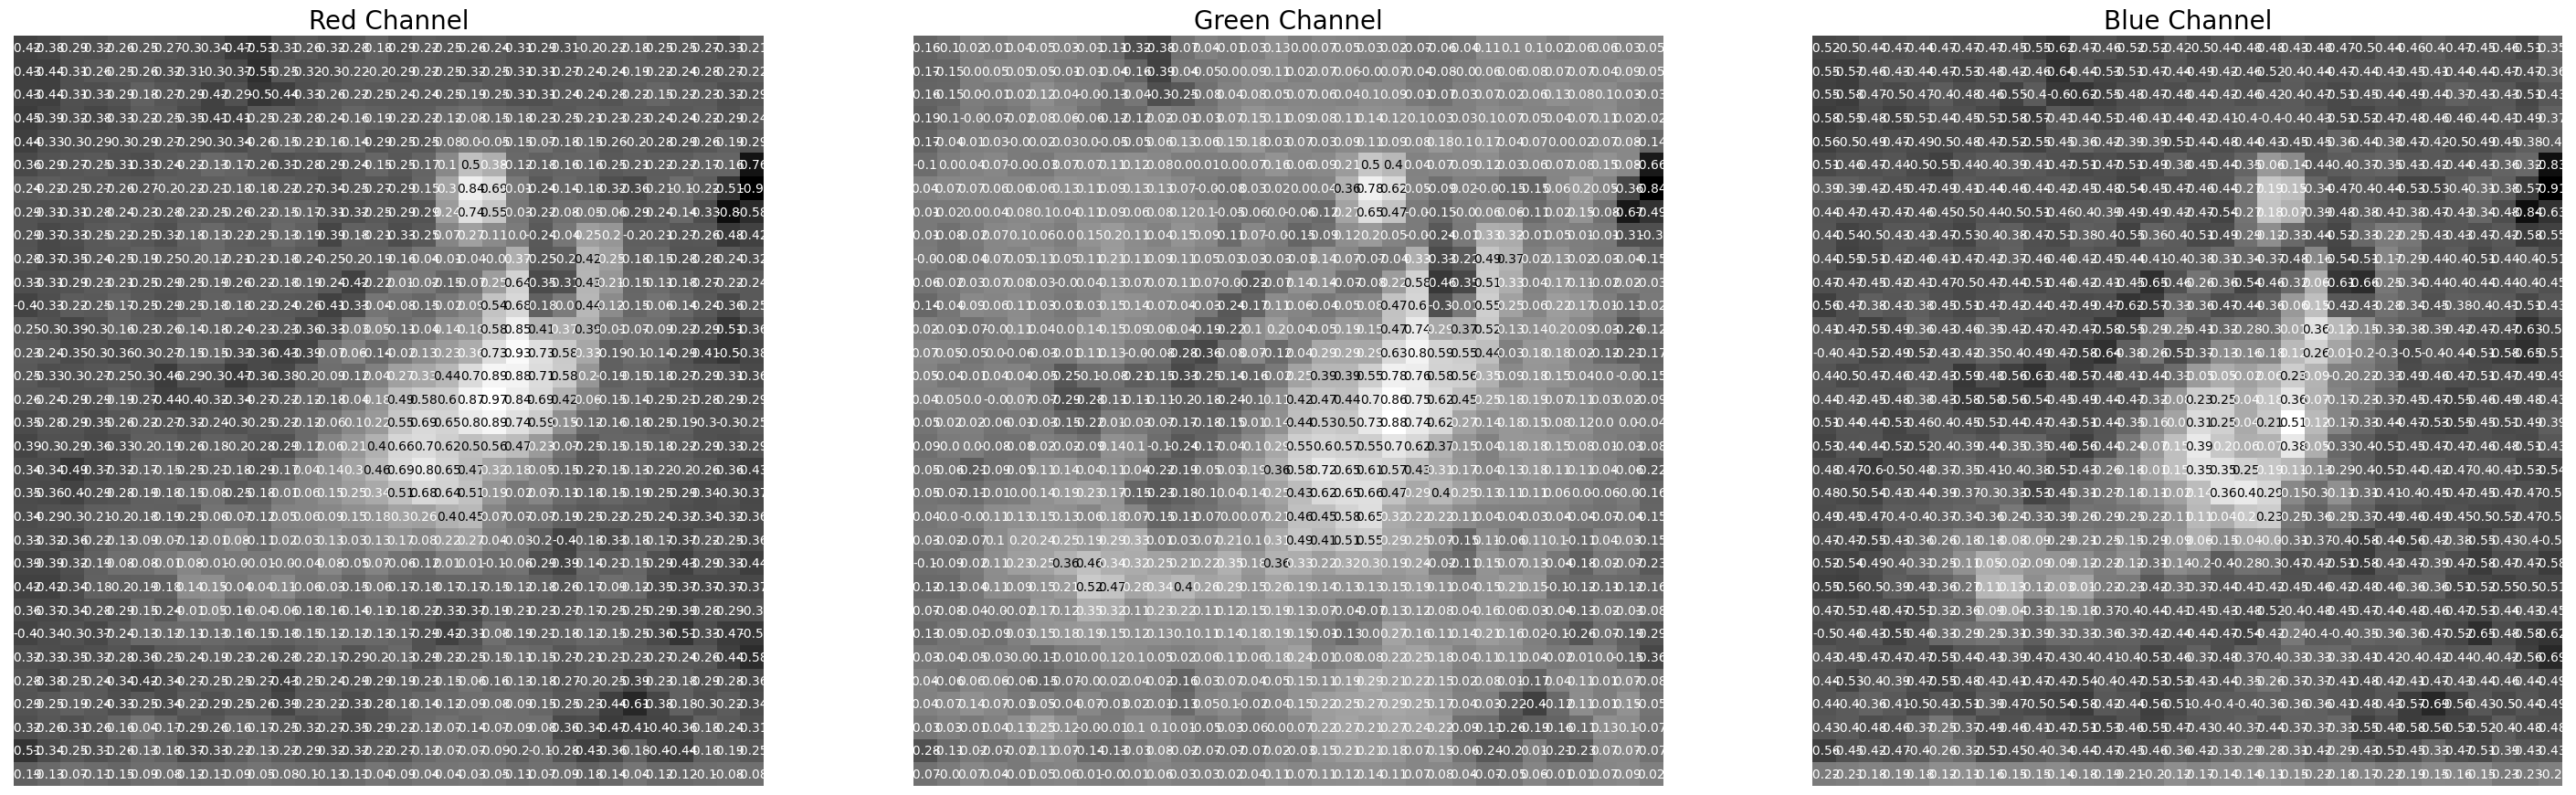

In [6]:
# Ensure images are on CPU and in NumPy format
if train_on_gpu:
    images = images.cpu().numpy()  # Convert to NumPy array if on GPU
else:
    images = images.numpy()  # Already in NumPy format on CPU

rgb_img = np.squeeze(images[3])  # Squeeze to remove any singleton dimensions
channels = ['Red Channel', 'Green Channel', 'Blue Channel']

# Create a figure to display the RGB channels
fig, axes = plt.subplots(1, 3, figsize=(36, 36))

# Display each channel separately as grayscale
for idx, ax in enumerate(axes):
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx], fontsize=20)

    # Get image dimensions
    width, height = img.shape
    thresh = img.max() / 2.5  # Set threshold for text color

    # Annotate pixel values on the image
    for x in range(width):
        for y in range(height):
            val = round(float(img[x][y]), 2) if img[x][y] != 0 else 0  # Convert to float before rounding
            ax.annotate(str(val), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=10,
                        color='white' if img[x][y] < thresh else 'black')
    ax.axis('off')

plt.show()


## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 32x32x3, Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input: 32x32x32, Output: 32x32x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input: 32x32x64, Output: 32x32x128

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)  # Reduces the size by half

        # Dropout Layer (to avoid overfitting)
        self.dropout = nn.Dropout(0.25)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Input from Conv3, Output to hidden layer
        self.fc2 = nn.Linear(512, 10)           # Output layer for 10 classes

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4

        # Flatten the input for fully connected layer
        x = x.view(x.size(0), -1)  # Flattening

        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [8]:
import torch.optim as optim

# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Compare two optimizers: SGD and Adam

# SGD Optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Adam Optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

# Print optimizers to compare settings
print("SGD Optimizer:", optimizer_sgd)
print("Adam Optimizer:", optimizer_adam)


SGD Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Adam Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

Epoch: 1 	Training Loss: 1.374303 	Validation Loss: 1.037178
Validation loss decreased (inf --> 1.037178).  Saving model ...
Epoch: 2 	Training Loss: 0.947148 	Validation Loss: 0.858611
Validation loss decreased (1.037178 --> 0.858611).  Saving model ...
Epoch: 3 	Training Loss: 0.759861 	Validation Loss: 0.818631
Validation loss decreased (0.858611 --> 0.818631).  Saving model ...
Epoch: 4 	Training Loss: 0.633440 	Validation Loss: 0.804280
Validation loss decreased (0.818631 --> 0.804280).  Saving model ...
Epoch: 5 	Training Loss: 0.527733 	Validation Loss: 0.749779
Validation loss decreased (0.804280 --> 0.749779).  Saving model ...
Epoch: 6 	Training Loss: 0.436290 	Validation Loss: 0.830554
Epoch: 7 	Training Loss: 0.362448 	Validation Loss: 0.843837
Epoch: 8 	Training Loss: 0.306700 	Validation Loss: 0.946066
Epoch: 9 	Training Loss: 0.263815 	Validation Loss: 0.970714
Epoch: 10 	Training Loss: 0.230685 	Validation Loss: 1.050577


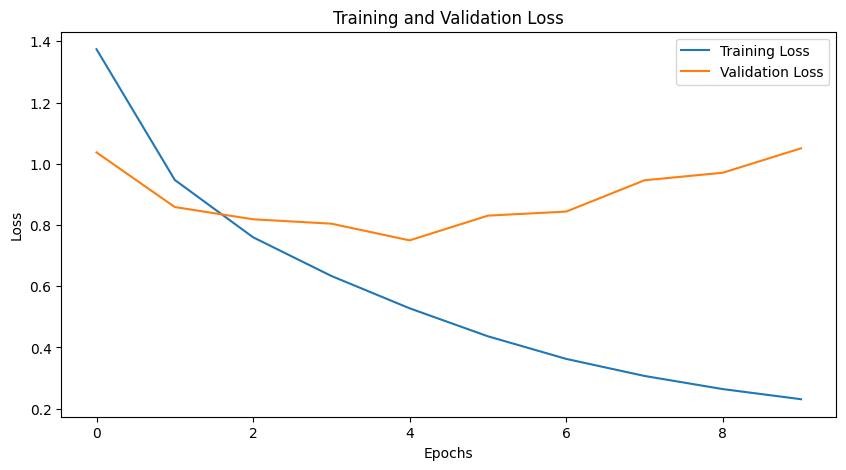

In [9]:
# Number of epochs to train the model
n_epochs = 10  # Increased to observe more learning progress

# Track change in validation loss
valid_loss_min = np.Inf

# Choose optimizer: either SGD or Adam
optimizer = optimizer_adam  # Switching to Adam for better convergence

# Lists to track loss for visualization
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():  # Turn off gradients for validation
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Calculate the batch loss
            loss = criterion(output, target)

            # Update average validation loss
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Append losses for visualization
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss

# Plotting the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [10]:
model.load_state_dict(torch.load('model_trained.pt'))

<ipython-input-10-1ebf1a10fb42>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_trained.pt'))


<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [11]:
# Track test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# Iterate over test data
with torch.no_grad():  # Turn off gradients for faster testing
    for batch_idx, (data, target) in enumerate(test_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss = criterion(output, target)

        # Update test loss
        test_loss += loss.item() * data.size(0)

        # Convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # Compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(correct_tensor.numpy())

        # Calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Print Test Accuracy for each class
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Overall Test Accuracy
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy,
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.768007

Test Accuracy of airplane: 77% (774/1000)
Test Accuracy of automobile: 84% (841/1000)
Test Accuracy of  bird: 66% (660/1000)
Test Accuracy of   cat: 48% (486/1000)
Test Accuracy of  deer: 73% (730/1000)
Test Accuracy of   dog: 70% (702/1000)
Test Accuracy of  frog: 81% (815/1000)
Test Accuracy of horse: 79% (792/1000)
Test Accuracy of  ship: 83% (835/1000)
Test Accuracy of truck: 81% (812/1000)

Test Accuracy (Overall): 74% (7447/10000)


### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

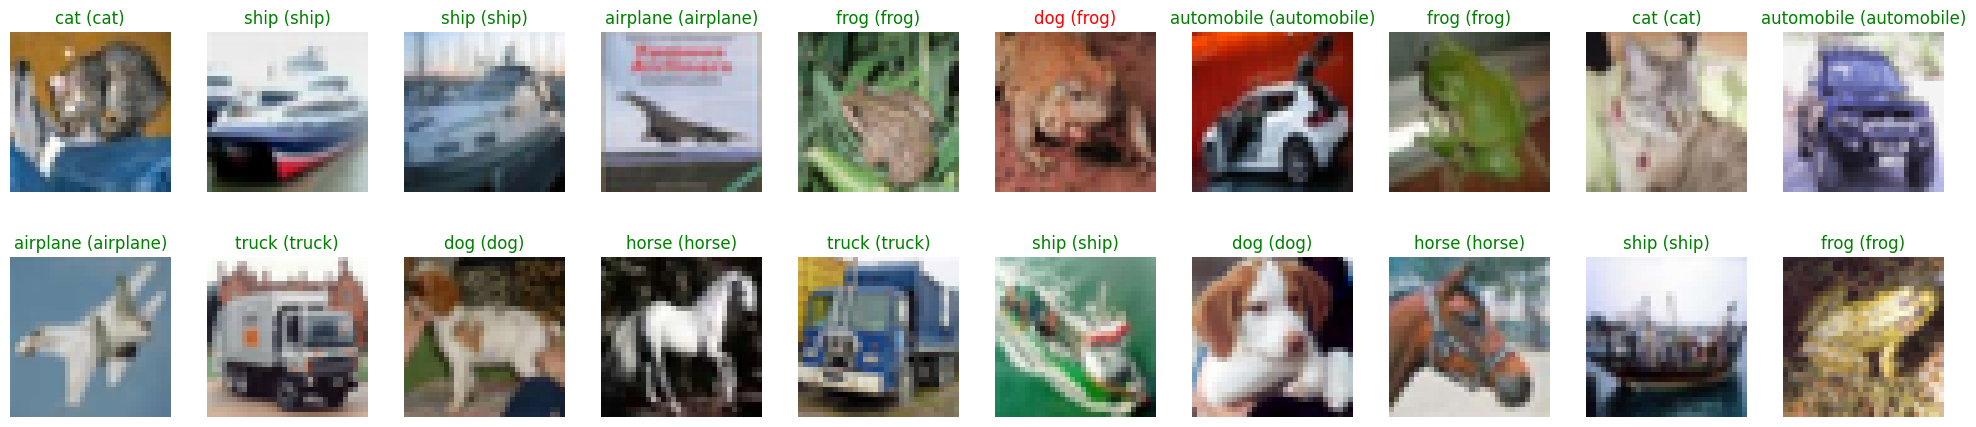

In [15]:
# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (assuming mean=0.5, std=0.5)
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert from Tensor image
    plt.axis('off')

# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move model inputs to GPU if available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = model(images)

# Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.cpu().numpy() if train_on_gpu else preds_tensor.numpy()

# Move images to CPU for display and un-normalize
images = images.cpu().numpy() if train_on_gpu else images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(25, 5))
fig.subplots_adjust(hspace=0.4)

# Display 20 images with predictions and true labels
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Un-normalize each image
        img = images[idx] / 2 + 0.5
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        ax.imshow(img)
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx].item()]),
                     color=("green" if preds[idx] == labels[idx].item() else "red"),
                     fontsize=12)
        ax.axis('off')

plt.show()
